In [2]:
%matplotlib inline

import sys
import os
sys.path.insert(0,os.path.expanduser('~/Library/Python/2.7/lib/python/site-packages/'))
import pandas as pd

import gym
import itertools
import matplotlib
import numpy as np
from __future__ import print_function

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.windy_gridworld import WindyGridworldEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [3]:
env = WindyGridworldEnv()

In [4]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [5]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
        
        Initialize Q(s, a), ∀s ∈ S, a ∈ A(s), arbitrarily, and Q(terminal-state, ·) = 0
        Repeat (for each episode):
            Initialize S
            Choose A from S using policy derived from Q (e.g., ε-greedy)
            Repeat (for each step of episode):
                Take action A, observe R, S′
                Choose A′ from S′ using policy derived from Q (e.g., ε-greedy)
                Q(S, A) ← Q(S, A) + α􏰃R + γQ(S′, A′) − Q(S, A)􏰄
                S ← S′; A ← A′;
            until S is termina
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    actions = np.array(xrange(env.action_space.n))

    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        state = env.reset()
        action = np.random.choice(actions, p=policy(state))
        done = False
        while not done:
            new_state, reward, done, _ = env.step(action)
            stats.episode_lengths[i_episode] += 1
            stats.episode_rewards[i_episode] += reward
            new_action = np.random.choice(actions, p=policy(new_state))
            Q[state][action] += alpha * (reward + discount_factor * Q[new_state][new_action] - Q[state][action])
            state = new_state
            action = new_action


    return Q, stats

In [6]:
Q, stats = sarsa(env, 300, discount_factor=0.9)

Episode 300/300.

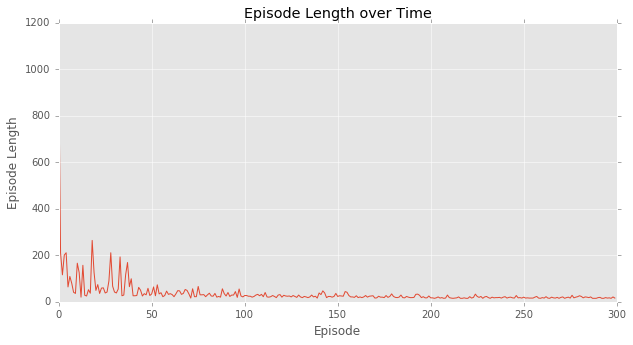

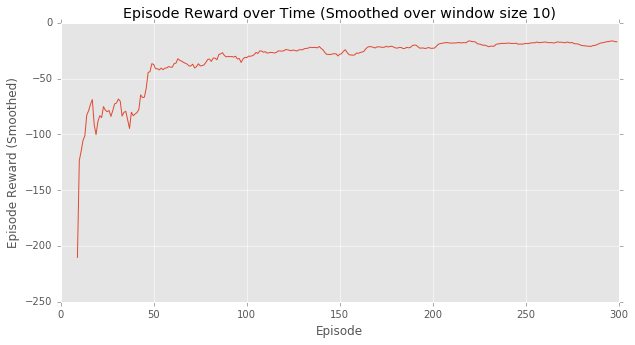

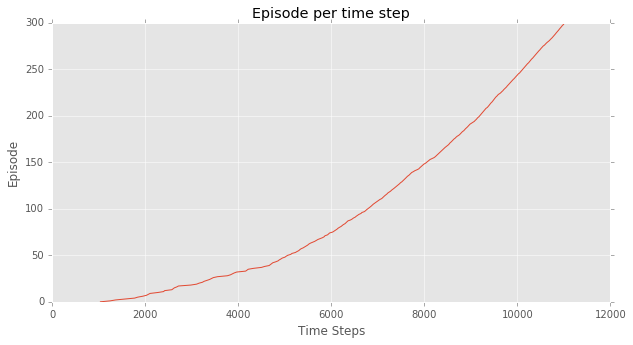

(<matplotlib.figure.Figure at 0x103ceb850>,
 <matplotlib.figure.Figure at 0x107bd8d50>)

In [7]:
print stats.episode_rewards[-]
plotting.plot_episode_stats(stats)